# Analiza projektów kickstarter

## Przygotowanie bibliotek wykorzystywanych w systemie

W systemie wykorzystywane są następujące biblioteki

- **pandas** - odczyt, zapis i operacje na danych
- **datetime** - operacje na datach
- **sklearn** - funkcje wykorzytywane w analizie PCA
- **math**, **numpy** - liczne funckje matematyczne
- **seaborn** - graficzna reprezentacja danych

In [673]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import math
import numpy as np
import seaborn as sns

## Przygotowanie początkowych stanów systemu

In [674]:
# Skonfigurowanie maksymalnej liczby wyświetlanych kolumn
pd.set_option('display.max_columns', 10)

# Skonfigurowanie opcji wyświetlania
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Parametry wykorzystywane przy wczytywaniu danych
dataset_path = './data/kickstarter-projects-filtered.csv'
encoding='ISO-8859-1'
rows_number = 1000
all_csv_columns = ['main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country']

# Dane wykorzystywane przy przetwarzaniu danych
all_columns = ['main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'pledged_ratio']
features_columns = ['main_category', 'deadline', 'goal', 'launched', 'pledged', 'backers', 'country', 'pledged_ratio']
labels_columns = ['state']

## Przygotowanie danych

 ### Wczytanie danych

In [675]:
df = pd.read_csv(dataset_path, encoding=encoding,low_memory=False).head(rows_number).filter(all_csv_columns, axis=1)
print(df.head())

  main_category currency        deadline     goal        launched  pledged       state  backers country
0    Publishing      GBP  09-10-15 11:36   1000.0  11-08-15 12:12      0.0      failed        0      GB
1  Film & Video      USD   26-02-13 0:20  45000.0   12-01-13 0:20    220.0      failed        3      US
2         Music      USD   16-04-12 4:24   5000.0   17-03-12 3:24      1.0      failed        1      US
3          Food      USD  01-04-16 13:38  50000.0  26-02-16 13:38  52375.0  successful      224      US
4          Food      USD  21-12-14 18:30   1000.0  01-12-14 18:30   1205.0  successful       16      US


### Konwersja danych tekstowych na dane liczbowe

Aby dane mogły zostać poprawnie przetworzone w dalszych krokach przy użyciu metody PCA, dane tekstowe należy zamienić na dane liczbowe. Do tego celu można wykorzystać słowniki. Algorytm konwersji jest następujący:
- zebrać wszystkie wartości występujące w danej kolumnie
- przyporządkować każdej wartości kolejną liczbę naturalną rozpoczynając od jedynki.

#### Metody pomocnicze

In [676]:
def get_all_values_from_column(df, col_name):
    values = []
    for i in range(0, len(df[col_name])):
        category = df[col_name][i]
        if category not in values:
            values.append(category)

    return values


def create_label_number_dict(names, start_from_zero = False):
    normalized = {}
    zero_margin = 1 - int(start_from_zero)
    for i in range(0, len(names)):
        name = names[i]
        normalized[name] = i + zero_margin

    return normalized

def map_text_to_number(df, column_name, dict):
    mapped = pd.Series(df[column_name].map(dict), name=column_name)
    df.update(mapped)

    return df

#### Zbieranie danych i tworzenie słowników

In [677]:
categories = get_all_values_from_column(df, 'main_category')
countries = get_all_values_from_column(df, 'country')
states = get_all_values_from_column(df, 'state')
currencies = get_all_values_from_column(df, 'currency')

categories_dict = create_label_number_dict(categories)
countries_dict = create_label_number_dict(countries)
states_dict = create_label_number_dict(states)
currencies_dict = create_label_number_dict(currencies)

#### Konwersja

In [678]:
# Map string values to number values
df = map_text_to_number(df, 'main_category', categories_dict)
df = map_text_to_number(df, 'country', countries_dict)
df = map_text_to_number(df, 'state', states_dict)
df = map_text_to_number(df, 'currency', currencies_dict)

### Konwersja dat na dane liczbowe

W przypadku dat przyjęto strategię reprezentacji ich jako **timestamp**

#### Metody pomocnicze

In [679]:
def date_to_timestamp(dt):
    return int(datetime.strptime(dt, "%d-%m-%y %H:%M").timestamp())


def map_date_to_timestamp(df, column_names):
    for column_name in column_names:
        mapped = pd.Series(df[column_name].map(date_to_timestamp), name=column_name)
        df.update(mapped)

    return df

#### Konwersja

In [680]:
df = map_date_to_timestamp(df, ['launched', 'deadline'])

### Dodanie sztucznej kolumny _pledged_ratio_

Kolumna ma określić jaki procent założonej sumy został zebrany

In [681]:
df['pledged_ratio'] = df['pledged'].astype(float) / df['goal'].astype(float) * 100

### Normalizowanie danych

In [682]:
colums_to_normalize = ['deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'pledged_ratio']
df[colums_to_normalize] = df[colums_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df.head()

,main_category,currency,deadline,goal,launched,pledged,state,backers,country,pledged_ratio
0,1,1,0.843787,0.000333,0.829356,0.000000,0.0,0.000000,1,0.000000e+00
1,2,2,0.489777,0.015000,0.481186,0.000261,0.0,0.000359,2,8.637613e-06
2,3,2,0.372739,0.001666,0.369917,0.000001,0.0,0.000120,2,3.533569e-07
3,4,2,0.90866,0.016666,0.902988,0.062075,1.0,0.026823,2,1.850707e-03
4,4,2,0.735716,0.000333,0.735904,0.001428,1.0,0.001916,2,2.128975e-03


Dla poprawności dalszych kroków można sprawdzić, czy któreś kolumny nie zawierają niepoprawnych/pustych danych

In [683]:
is_any_nan = False
for column in all_csv_columns:
    is_any_nan = is_any_nan or df[column].isnull().values.any()

print(f'\nCzy istnieją nieprawidłowe wartości w zbiorze danych: {is_any_nan}\n')


Czy istnieją nieprawidłowe wartości w zbiorze danych: False



## Wybór cech i etykiet


In [684]:
features = df[all_columns]
labels = df[labels_columns]

## Analiza PCA

TODO: Parę słów o analizie PCA


### Przeskalowanie wartości

In [685]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

### Stworzenie macierzy kowariancji i wygenerowanie heatmapy

{'main_category': 0, 'currency': 1, 'deadline': 2, 'goal': 3, 'launched': 4, 'pledged': 5, 'state': 6, 'backers': 7, 'country': 8, 'pledged_ratio': 9}


<AxesSubplot:>

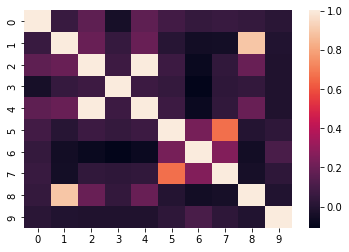

In [686]:
covariance_matrix = np.cov(features_scaled.T)

columns_dict = create_label_number_dict(all_columns, True)
print(columns_dict)
sns.heatmap(covariance_matrix)

Kolumną decyzyjną jest kolumna numer 6 - jest to kolumna mówiąca o tym, czy startap zakończył porażką (1) czy sukcesem (2)
Z heatmapy wynika korelacja następujących 3 kolumn z kolumną decyzyjną:

|  Kolumna 1  |  Kolumna 2  |     Kolumna 3     |
|:-----------:|:-----------:|:-----------------:|
| pledged (5) | backers (7) | pledged_ratio (9) |

### Wartości i wektory Eigena

In [687]:
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
print(eigen_values)

[2.39135829e+00 1.86861145e+00 1.54873505e+00 1.97631863e-04
 1.07939092e-01 3.32336698e-01 1.10002580e+00 9.88673078e-01
 9.05909766e-01 7.66223155e-01]


## KNN K-means

In [688]:

class Startup:
    def __init__(self, dataframe_row):
        self.main_category = dataframe_row['main_category']
        self.currency = dataframe_row['currency']
        self.deadline = dataframe_row['deadline']
        self.goal = dataframe_row['goal']
        self.launched = dataframe_row['launched']
        self.pledged = dataframe_row['pledged']
        self.state = dataframe_row['state']
        self.backers = dataframe_row['backers']
        self.country = dataframe_row['country']
        self.pledged_ratio = dataframe_row['pledged_ratio']

    def to_string(self):
        print(f'category: {self.main_category}, state: {self.state}')


class KnnKMeans:
    def __init__(self, df):
        self.df = df
        self.count = df['state'].count()
        self.startups = self.create_startups_objects(df)

    def create_startups_objects(self, df):
        count = df['state'].count()
        objects = []
        for i in range(0, count):
            objects.append(Startup(df.loc[i]))
        return objects

    def classify(self, unknown, k):
        measured_distances = []
        k_closest = []

        # Calculate distances
        for i in range(0, len(self.startups)):
            startup = self.startups[i]
            distance = self.get_distance(unknown, startup)
            measured_distances.append({ 'index': i, 'distance': distance, 'class': startup.state })

        # Sort by lower distance
        measured_distances = sorted(measured_distances, key=lambda item: item['distance'])

        # Select the k closest neighbours
        for i in range(0, k):
            k_closest.append(measured_distances[i])

        dominant_class = self.get_dominant_class(k_closest)
        self.print_selected_closest_neighbours(k_closest)
        print(f'Based on {k} nearest neighbours, the unknown element belongs to \'{dominant_class}\' class ')

    def get_dominant_class(self, closest):
        classes_dict = {}
        for el in closest:
            class_name = el["class"]
            if class_name not in classes_dict.keys():
                classes_dict[class_name] = 0
            current_class_count_value = int(classes_dict.get(class_name))
            classes_dict[class_name] = current_class_count_value + 1

        return max(classes_dict, key=classes_dict.get)



    def get_all_classes(self, closest):
        classes = []
        for el in closest:
            new_class = el['class']
            if new_class not in classes:
                classes.append(el['class'])
        return classes

    def print_selected_closest_neighbours(self, closest):
        print(f'The {len(closest)} closest neighbours of given element')
        lp = 1
        for neighbour in closest:
            print(f'  {lp}. Distance: {neighbour["distance"]} class:{neighbour["class"]}')
            lp += 1

    def get_distance(self, startup1, startup2):
        return math.sqrt(
            math.pow(startup2.main_category - startup1.main_category, 2)
            + math.pow(startup2.currency - startup1.currency, 2)
            + math.pow(startup2.deadline - startup1.deadline, 2)
            + math.pow(startup2.goal - startup1.goal, 2)
            + math.pow(startup2.launched - startup1.launched, 2)
            + math.pow(startup2.pledged - startup1.pledged, 2)
            + math.pow(startup2.backers - startup1.backers, 2)
            + math.pow(startup2.country - startup1.country, 2)
            + math.pow(startup2.pledged_ratio - startup1.pledged_ratio, 2)
        )

In [689]:
unknown = df.loc[999]
knn = KnnKMeans(df)
knn.classify(unknown, 7)

The 7 closest neighbours of given element
  1. Distance: 0.0 class:0.0
  2. Distance: 0.023700662068344897 class:0.0
  3. Distance: 0.029167855108173463 class:1.0
  4. Distance: 0.034576159368031135 class:1.0
  5. Distance: 0.04148180373342347 class:0.0
  6. Distance: 0.04851547908447429 class:1.0
  7. Distance: 0.049083688627265254 class:1.0
Based on 7 nearest neighbours, the unknown element belongs to '1.0' class 
